In [1]:
%autosave 30
from IPython.display import display, HTML
display(HTML('<style>.container {width:100% !important;}</style>'))
import importlib as imp
import utils_models as fx
import glob

Autosaving every 30 seconds


### Training models in a loop
- Run this cell only if models have not already been trained
- Otherwise move to next cell (models are only loaded, not trained)

In [ ]:
run_from_scratch = False
imp.reload(fx)
import gc
pattern = '*.pkl'
matching_files = glob.glob(pattern)
names_dict = {}
times_dict = {}

if run_from_scratch: 
    for file_path in matching_files:
        file_name = file_path.split("/")[-1]
        NAME = file_path.split('_')[0]
        TIME = file_path.split('_')[1]  # Remove the file extension
        if NAME not in names_dict:
            names_dict[NAME] = []
        if NAME not in times_dict:
            times_dict[NAME] = []
        names_dict[NAME].append(TIME)
        times_dict[NAME].append(TIME) 


    name_time_list = []
    for name, times in times_dict.items():
        for time in times:
            name_time_list.append((name, time))

    names_to_test = set([i for i,_ in name_time_list])

    for name_testing_subject in names_to_test:
        print(f'================={name_testing_subject}=================')
        try: 
            del testing_data, training_data, testing_states, training_states
            gc.collect()
        except:
            pass

        testing_data = []; training_data = [] 
        testing_states = []; training_states = []
        print('Organizing data...')

        for name, time in name_time_list:

            #read data
            data, states = fx.read_data_and_metadata(name, time, best_channel=True)

            if name == name_testing_subject:
                testing_data.append(data)
                testing_states.extend(states)
            else:
                training_data.append(data)
                training_states.extend(states)

        testing_data = np.concatenate(testing_data, axis=0)
        training_data = np.concatenate(training_data, axis=0)

        print('Building Model 1...')
        treshold_mod1 = 0.9
        cm1, unknown_counts1 = fx.model1(name_testing_subject, 
                                         training_data, 
                                         training_states, 
                                         testing_data, 
                                         testing_states, 
                                         treshold_mod1,
                                         norm=True)  # if normalize_data = False, means that we normalize it across subject BEFORE loop across subjects!!!

        print('Building Model 2...')
        treshold_mod2 = 0.85
        fx.mod2(name_testing_subject, training_data, training_states, testing_data, testing_states, treshold_mod2, norm=True)

### Models are already trained
This cell allows you to load the trained models on each subject (classical leave-one-out) and save the corresponding data and labels for further processing

In [ ]:
imp.reload(fx)
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import gc
pattern = '*.pkl'
matching_files = glob.glob(pattern)
names_dict = {}
times_dict = {}

for file_path in matching_files:
    file_name = file_path.split("/")[-1]
    NAME = file_path.split('_')[0]
    TIME = file_path.split('_')[1]  # Remove the file extension
    if NAME not in names_dict:
        names_dict[NAME] = []
    if NAME not in times_dict:
        times_dict[NAME] = []
    names_dict[NAME].append(TIME)
    times_dict[NAME].append(TIME)

    
name_time_list = []
for name, times in times_dict.items():
    for time in times:
        if name != 'metrics':
            name_time_list.append((name, time))
        
names_to_test = set([i for i,_ in name_time_list])
names_to_test = ['Monica', 'Natasha', 'Phoebe', 'Skipper']

for name_testing_subject in names_to_test:
    print(f'================={name_testing_subject}=================')
    try: 
        del testing_data, training_data, testing_states, training_states
        gc.collect()
    except:
        pass

    testing_data = []; training_data = [] 
    testing_states = []; training_states = []
    print('Organizing data...')

    for name, time in name_time_list:

        #read data
        data, states = fx.read_data_and_metadata(name, time, best_channel=True)

        if name == name_testing_subject:
            testing_data.append(data)
            testing_states.extend(states)
        else:
            training_data.append(data)
            training_states.extend(states)

    testing_data = np.concatenate(testing_data, axis=0)
    training_data = np.concatenate(training_data, axis=0)
    model = fx.CNN()
    model_path = f"models_trainmain/primary_model_epoch_{name_testing_subject}_6.pth"
    model.load_state_dict(torch.load(model_path))
    print(f"Loaded model from {model_path}")
    
    test_data_normalized = fx.normalize_data(testing_data)
    test_labels_numeric = fx.labels_to_numbers(testing_states)
    test_dataset = TensorDataset(torch.tensor(test_data_normalized, dtype=torch.float32).unsqueeze(1),
                                 torch.tensor(test_labels_numeric, dtype=torch.long))
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    all_preds, all_labels = [], []
    all_preds_prob, all_labels_prob = [], []
    probs = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            _, preds_prob = torch.max(probabilities, 1)
            # preds[probabilities.max(dim=1).values < treshold_mod1] = -1
            all_preds_prob.extend(preds_prob.cpu().numpy())
            all_labels_prob.extend(labels.numpy())
            probs.append(list(probabilities.numpy()[0]))

    df_pred = pd.DataFrame({'all_preds_prob': all_preds_prob, 'all_labels_prob': all_labels_prob, 'prob': probs})
    df_pred.to_pickle(f'model_df_probs/df_pred_model1_{name_testing_subject}')        

    treshold_mod2 = 0.85
    y_pred, predictions, true_classes, data_test_MA, labels_test_MA = fx.mod2(name_testing_subject, training_data, training_states, testing_data, testing_states, treshold_mod2, LEAVEONEOUT, norm=True) 
    
    # apppend to dataframe
    df_pred = pd.DataFrame({'y_pred': y_pred.reshape(1, -1)[0], 'predictions': predictions.reshape(1, -1)[0], 'true_classes': true_classes})
    df_pred.to_pickle(f'model_df_probs/df_pred_model2_{name_testing_subject}_loo')
        
    # save testing data
    np.save(f'testing_data/testing_data_{name_testing_subject}.npy', testing_data)
    np.save(f'testing_data/testing_labels_{name_testing_subject}.npy', testing_states)
    np.save(f'testing_data/testing_dataMA_{name_testing_subject}.npy', data_test_MA)
    np.save(f'testing_data/testing_labelsMA_{name_testing_subject}.npy', labels_test_MA)


### Threshold analysis
The cell below allows you to perform an analysis of the accuracy with respect to the confidence threshold used.
- If a sample is below the confindence threshold, it is labelled as unknown and needs further processing. 
- In the case of asynch_MA and slow_MA, the confidence threshold is thr and 1-th respectively, where `x` in `1-thr <= x <= thr` is labelled as unknown, being `thr > 0.5`

In [ ]:
confusion_matrix(df_pred['all_labels_prob'], df_pred['y_prob'], labels=[0, 1, 2])

In [2]:
import os
import pickle
import pandas as pd
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

pattern = '*.pkl'
matching_files = glob.glob(pattern)
matching_files = [i for i in matching_files if not i.startswith('metrics')]
names_dict = {}
times_dict = {}

for file_path in matching_files:
    file_name = file_path.split("/")[-1]
    NAME = file_path.split('_')[0]
    TIME = file_path.split('_')[1]  # Remove the file extension
    if NAME not in names_dict:
        names_dict[NAME] = []
    if NAME not in times_dict:
        times_dict[NAME] = []
    names_dict[NAME].append(TIME)
    times_dict[NAME].append(TIME)

    
name_time_list = []
for name, times in times_dict.items():
    for time in times:
        name_time_list.append((name, time))
        
names_to_test = set([i for i,_ in name_time_list])


df_acc = pd.DataFrame(columns=['sub', 'state', 'value', 'thr', 'to_unknown', 'to_unknown_notnorm', 'num_samples_state'])
df_acc_MA = pd.DataFrame(columns=['sub', 'state', 'value', 'thr', 'to_unknown', 'to_unknown_notnorm', 'num_samples_state'])
df_acc_wUK = pd.DataFrame(columns=['sub', 'state', 'value', 'thr', 'num_samples_state'])
df_acc_MA_wUK = pd.DataFrame(columns=['sub', 'state', 'value', 'thr', 'num_samples_state'])
# initialize precision, recall and f1score df
df_metrics = pd.DataFrame(columns=['sub', 'model', 'thr', 'precision', 'recall', 'f1'])
df_metrics_nounknown = pd.DataFrame(columns=['sub', 'model', 'thr', 'precision', 'recall', 'f1'])

for threshold in np.arange(0.4, 1.0, 0.05):
    clear_output()
    print(f'Threshold: {threshold}')
    thr = [threshold, threshold]
    
    for name_testing_subject in ['Skipper', 'Monica', 'Phoebe', 'Natasha']: # names_to_test:
        
        # read dataframe for model 1
        df_pred = pd.read_pickle(os.getcwd() + f'/model_df_probs/df_pred_model1_{name_testing_subject}')

        # apply threshold filter
        df_pred['y_prob'] = [df_pred['all_preds_prob'].iloc[p] if np.max(df_pred['prob'].iloc[p]) > thr[0] else -1 for p in range(len(df_pred['prob']))]

        # compute confusion matrix
        cm = confusion_matrix(df_pred['all_labels_prob'], df_pred['y_prob'], labels=[0, 1, 2, -1])
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        with open(f'testing_data/cm_model1_{name_testing_subject}_thr_{np.round(thr[0],2)}.pkl', "wb") as pickle_file:
            pickle.dump({'cm': cm, 'cm_n': cm_normalized}, pickle_file)
            
        # compute confusion matrix WITHOUT UNKNOWNS
        cm_wUK = confusion_matrix(df_pred['all_labels_prob'], df_pred['y_prob'], labels=[0, 1, 2])
        cm_normalized_wUK = cm_wUK.astype('float') / cm_wUK.sum(axis=1)[:, np.newaxis]
        
        with open(f'testing_data/cm_wUK_model1_{name_testing_subject}_thr_{np.round(thr[0],2)}.pkl', "wb") as pickle_file:
            pickle.dump({'cm': cm_wUK, 'cm_n': cm_normalized_wUK}, pickle_file)

        # compute accuracy dataframe including unknowns
        state_dict = {0: 'AW', 1: 'SO', 2: 'MA', -1: 'unknown'}
        for i in state_dict.keys():
            # append to df
            df_acc = pd.concat([df_acc, pd.DataFrame({
                'sub': name_testing_subject, 
                'state': state_dict[i], 
                'value': [cm_normalized[i, i]],
                'thr': [np.round(thr[0],2)],
                'to_unknown': [cm_normalized[i, -1]],
                'to_unknown_notnorm': [cm[i, -1]],
                'num_samples_state': [np.sum(cm[i, :])],
            })], ignore_index=True)
            
        # compute accuracy dataframe excluding unknowns
        state_dict_wUK = {0: 'AW', 1: 'SO', 2: 'MA'}
        for i in state_dict_wUK.keys():
            # append to df
            df_acc_wUK = pd.concat([df_acc_wUK, pd.DataFrame({
                'sub': name_testing_subject, 
                'state': state_dict_wUK[i], 
                'value': [cm_normalized_wUK[i, i]],
                'thr': [np.round(thr[0],2)],
                'num_samples_state': [np.sum(cm_wUK[i, :])],
            })], ignore_index=True)
            
        # get metrics for precision, recall and f1
        df_metrics = pd.concat([df_metrics, pd.DataFrame({
            'sub': name_testing_subject, 
            'model': [1], 
            'thr': [thr[0]],
            'precision': [precision_score(df_pred['all_labels_prob'], df_pred['y_prob'], average='macro')], 
            'recall': [recall_score(df_pred['all_labels_prob'], df_pred['y_prob'], average='macro')], 
            'f1': [f1_score(df_pred['all_labels_prob'], df_pred['y_prob'], average='macro')],
        })], ignore_index=True)
        
        # do the same metrics but without taking into account unknowns
        val_nounknowns = df_pred.loc[df_pred['y_prob']!=-1].index.values
        df_metrics_nounknown = pd.concat([df_metrics_nounknown, pd.DataFrame({
            'sub': name_testing_subject, 
            'model': [1], 
            'thr': [thr[0]],
            'precision': [precision_score(df_pred['all_labels_prob'].iloc[val_nounknowns], df_pred['y_prob'].iloc[val_nounknowns], average='macro')], 
            'recall': [recall_score(df_pred['all_labels_prob'].iloc[val_nounknowns], df_pred['y_prob'].iloc[val_nounknowns], average='macro')], 
            'f1': [f1_score(df_pred['all_labels_prob'].iloc[val_nounknowns], df_pred['y_prob'].iloc[val_nounknowns], average='macro')],
        })], ignore_index=True)


        # read df model 2
        df_mod2 = pd.read_pickle(os.getcwd() + f'/model_df_probs/df_pred_model2_{name_testing_subject}')

        # threshold
        predicted_classes = np.where(df_mod2['predictions'] > thr[1], 1, 
                                     np.where(df_mod2['predictions'] <= 1 - thr[1], 0, -1)).flatten()
        
        # compute confusion matrix
        cm = confusion_matrix(df_mod2['true_classes'], predicted_classes, labels=[0, 1, -1])
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        with open(f'testing_data/cm_model2_{name_testing_subject}_thr_{np.round(thr[1],2)}.pkl', "wb") as pickle_file:
            pickle.dump({'cm': cm, 'cm_n': cm_normalized}, pickle_file)
            
        # compute confusion matrix WITHOUT UNKNOWNS
        cm_wUK = confusion_matrix(df_mod2['true_classes'], predicted_classes, labels=[0, 1])
        cm_normalized_wUK = cm_wUK.astype('float') / cm_wUK.sum(axis=1)[:, np.newaxis]
        with open(f'testing_data/cm_wUK_model2_{name_testing_subject}_thr_{np.round(thr[1],2)}.pkl', "wb") as pickle_file:
            pickle.dump({'cm': cm_wUK, 'cm_n': cm_normalized_wUK}, pickle_file)

        
        df_metrics = pd.concat([df_metrics, pd.DataFrame({
            'sub': name_testing_subject, 
            'model': [2], 
            'thr': [thr[1]],
            'precision': [precision_score(df_mod2['true_classes'], predicted_classes, average='macro')], 
            'recall': [recall_score(df_mod2['true_classes'], predicted_classes, average='macro')], 
            'f1': [f1_score(df_mod2['true_classes'], predicted_classes, average='macro')],
        })], ignore_index=True)
        
        # do the same metrics but without taking into account unknowns
        val_nounknowns_mod2 = np.where(predicted_classes!=-1)[0]        
        df_metrics_nounknown = pd.concat([df_metrics_nounknown, pd.DataFrame({
            'sub': name_testing_subject, 
            'model': [2], 
            'thr': [thr[1]],
            'precision': [precision_score(df_mod2['true_classes'].iloc[val_nounknowns_mod2], predicted_classes[val_nounknowns_mod2], average='macro')], 
            'recall': [recall_score(df_mod2['true_classes'].iloc[val_nounknowns_mod2], predicted_classes[val_nounknowns_mod2], average='macro')], 
            'f1': [f1_score(df_mod2['true_classes'].iloc[val_nounknowns_mod2], predicted_classes[val_nounknowns_mod2], average='macro')],
        })], ignore_index=True)
        
        # compute accuracy dataframe including unknowns
        state_dict_mod2 = {0: 'asynch_MA', 1: 'slow_MA', -1:'unknown'}
        for i in state_dict_mod2.keys():
            # append to df
            df_acc_MA = pd.concat([df_acc_MA, pd.DataFrame({
                'sub': name_testing_subject, 
                'state': state_dict_mod2[i], 
                'value': [cm_normalized[i, i]],
                'thr': [np.round(thr[1],2)],
                'to_unknown': [cm_normalized[i, -1]],
                'to_unknown_notnorm': [cm[i, -1]],
                'num_samples_state': [np.sum(cm[i, :])],
            })], ignore_index=True)
        
        # compute accuracy dataframe excluding unknowns
        state_dict_mod2_wUK = {0: 'asynch_MA', 1: 'slow_MA'}
        for i in state_dict_mod2_wUK.keys():
            # append to df
            df_acc_MA_wUK = pd.concat([df_acc_MA_wUK, pd.DataFrame({
                'sub': name_testing_subject, 
                'state': state_dict_mod2_wUK[i], 
                'value': [cm_normalized_wUK[i, i]],
                'thr': [np.round(thr[1],2)],
                'num_samples_state': [np.sum(cm_wUK[i, :])],
            })], ignore_index=True)
        

Threshold: 0.9499999999999998


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site

### Compute percentage (all subjects) of samples going to uknown
- These unknown samples will undergo further processing (AE + centroids)

In [3]:
# define threshold
thr = 0.9

df_acc_thr = df_acc.loc[df_acc['thr']==thr]
df_acc_MA_thr = df_acc_MA.loc[df_acc_MA['thr']==thr]

# the above cell needs to be executed only for the 4 subjects and for threshold 0.9
print(f"Model 1: The number of unknowns is {np.round(100* df_acc_thr['to_unknown_notnorm'].values.sum() / df_acc_thr['num_samples_state'].values.sum(), 2)}% of the total number of samples")
print(f"Model 2: The number of unknowns is {np.round(100* df_acc_MA_thr['to_unknown_notnorm'].values.sum() / df_acc_MA_thr['num_samples_state'].values.sum(), 2)}% of the total number of samples")

for state in [i for i in set(df_acc_thr['state']) if i != 'unknown']:
    print(f"Model 1 {state}: {np.round(100* df_acc_thr.loc[df_acc_thr['state']==state]['to_unknown_notnorm'].values.sum() / df_acc_thr.loc[df_acc_thr['state']==state]['num_samples_state'].values.sum(), 2)}%")

for state in [i for i in set(df_acc_MA_thr['state']) if i != 'unknown']:
    print(f"Model 2 {state}: {np.round(100* df_acc_MA_thr.loc[df_acc_MA_thr['state']==state]['to_unknown_notnorm'].values.sum() / df_acc_MA_thr.loc[df_acc_MA_thr['state']==state]['num_samples_state'].values.sum(), 2)}%")

Model 1: The number of unknowns is 8.01% of the total number of samples
Model 2: The number of unknowns is 29.96% of the total number of samples
Model 1 MA: 5.66%
Model 1 AW: 13.12%
Model 1 SO: 9.4%
Model 2 slow_MA: 38.3%
Model 2 asynch_MA: 22.59%


### Figure: Unknown percentage as a function of the threshold
- For each subject and state, compute the percentage of unknowns with respect to the confidence threshold used
- As expected, the higher the condifence threshold the higher the number of unknowns

<IPython.core.display.Javascript object>


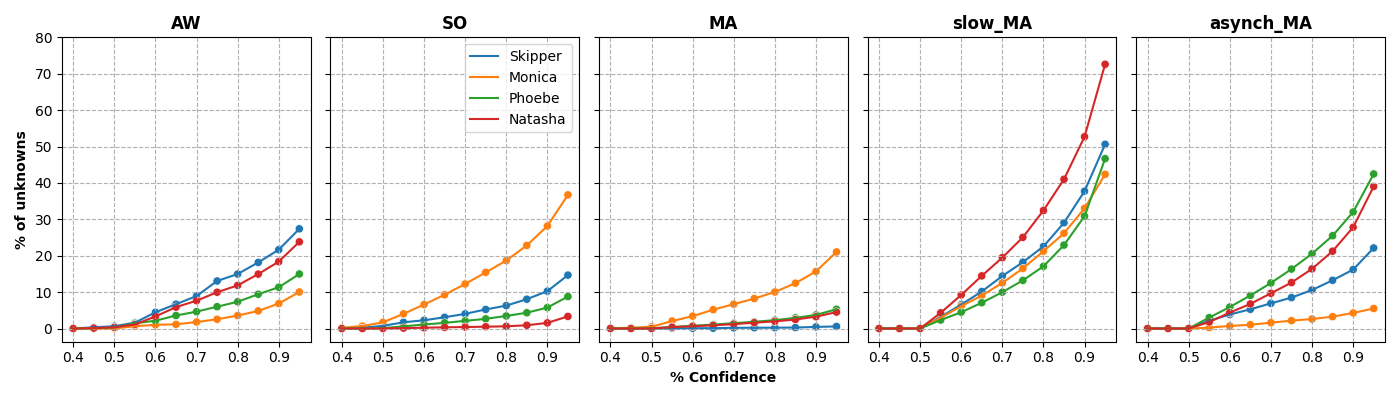

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(ncols=5, figsize=(14, 4), sharex=True, sharey=True)
leg_viz = False
for sdx, state in enumerate(['AW', 'SO', 'MA']):
    leg_viz = True if sdx == 1 else False
    sns.lineplot(data=df_acc.loc[df_acc['state']==state], x='thr', y='to_unknown', hue='sub', ax=ax[sdx], legend=leg_viz)
    sns.scatterplot(data=df_acc.loc[df_acc['state']==state], x='thr', y='to_unknown', hue='sub', ax=ax[sdx], legend=False)
    ax[sdx].set_title(f'{state}', fontweight='bold')
    ax[sdx].set_xlabel('')
    ax[sdx].grid(linestyle='--')
    if leg_viz: 
        ax[sdx].legend(loc=1)

for sdx, state in enumerate(['slow_MA', 'asynch_MA']):
    sns.lineplot(data=df_acc_MA.loc[df_acc_MA['state']==state], x='thr', y='to_unknown', hue='sub', ax=ax[sdx+3], legend=False)
    sns.scatterplot(data=df_acc_MA.loc[df_acc_MA['state']==state], x='thr', y='to_unknown', hue='sub', ax=ax[sdx+3], legend=False)
    ax[sdx + 3].set_title(f'{state}', fontweight='bold')
    ax[sdx + 3].set_xlabel('')
    ax[sdx + 3].grid(linestyle='--')


# fig.suptitle()
ax[sdx].set_yticks([0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8])
ax[0].set_yticklabels([int(i*100) for i in ax[0].get_yticks()])
ax[0].set_ylabel('% of unknowns', fontweight='bold')
ax[0].set_xticks(np.arange(0.4, 1.0, 0.1))
ax[2].set_xlabel('% Confidence', fontweight='bold')
plt.tight_layout()
plt.savefig('C:\\Users\\manasanch.IBP10386\\Downloads\\unknowns_percentage.jpg')
plt.savefig('C:\\Users\\manasanch.IBP10386\\Downloads\\unknowns_percentage.svg', dpi=600)

### Figure: Accuracies of state dependant of the threshold INCLUDING UNKNOWNS
- Plot of the accuracies obtained (by state and subject) when choosing different confidence thresholds

<IPython.core.display.Javascript object>


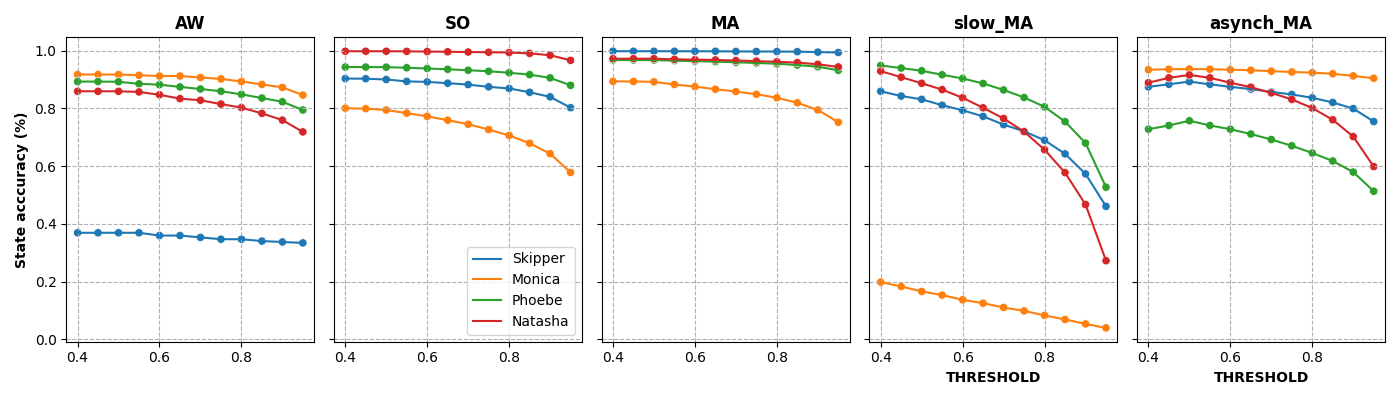

In [12]:
fig, ax = plt.subplots(ncols=5, figsize=(14, 4), sharex=False, sharey=True)
for sdx, state in enumerate(['AW', 'SO', 'MA']):
    leg_viz = True if sdx == 1 else False
    sns.lineplot(data=df_acc.loc[df_acc['state']==state], x='thr', y='value', hue='sub', ax=ax[sdx], legend=leg_viz)
    sns.scatterplot(data=df_acc.loc[df_acc['state']==state], x='thr', y='value', hue='sub', ax=ax[sdx], legend=False)
    ax[sdx].set_title(f'{state}', fontweight='bold')
    ax[sdx].set_xlabel('')
    ax[sdx].grid(linestyle='--')
    if leg_viz: 
        ax[sdx].legend(loc=4)

for sdx, state in enumerate(['slow_MA', 'asynch_MA']):
    sns.lineplot(data=df_acc_MA.loc[df_acc_MA['state']==state], x='thr', y='value', hue='sub', ax=ax[sdx+3], legend=False)
    sns.scatterplot(data=df_acc_MA.loc[df_acc_MA['state']==state], x='thr', y='value', hue='sub', ax=ax[sdx+3], legend=False)
    ax[sdx+3].set_title(f'{state}', fontweight='bold')
    ax[sdx+3].set_xlabel('THRESHOLD', fontweight='bold')
    ax[sdx+3].grid(linestyle='--')

ax[0].set_ylabel('State acccuracy (%)', fontweight='bold')
plt.tight_layout()

### Figure: Accuracies of state dependant of the threshold EXCLUDING UNKNOWNS
- Plot of the accuracies obtained (by state and subject) when choosing different confidence thresholds

<IPython.core.display.Javascript object>


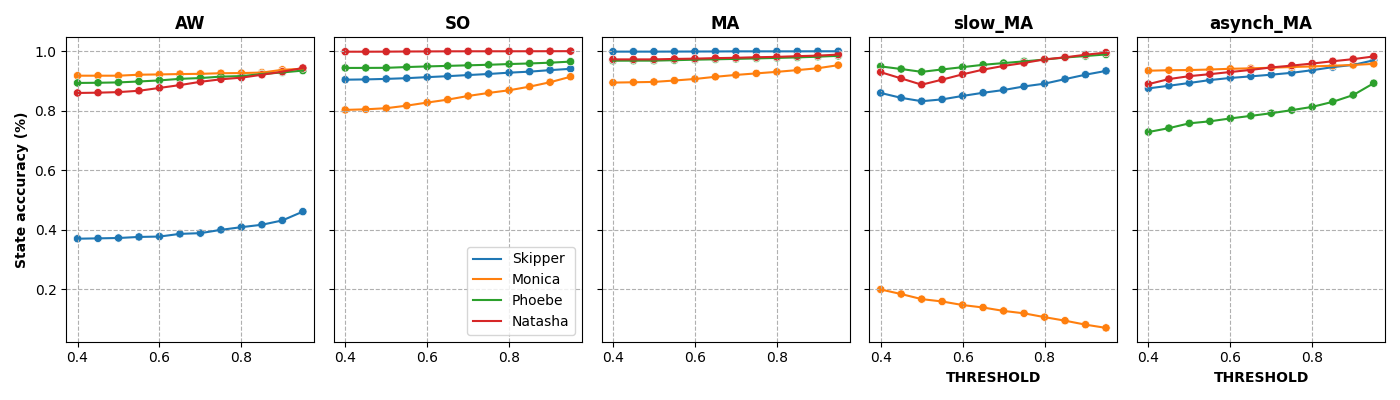

In [15]:
fig, ax = plt.subplots(ncols=5, figsize=(14, 4), sharex=False, sharey=True)
for sdx, state in enumerate(['AW', 'SO', 'MA']):
    leg_viz = True if sdx == 1 else False
    sns.lineplot(data=df_acc_wUK.loc[df_acc_wUK['state']==state], x='thr', y='value', hue='sub', ax=ax[sdx], legend=leg_viz)
    sns.scatterplot(data=df_acc_wUK.loc[df_acc_wUK['state']==state], x='thr', y='value', hue='sub', ax=ax[sdx], legend=False)
    ax[sdx].set_title(f'{state}', fontweight='bold')
    ax[sdx].set_xlabel('')
    ax[sdx].grid(linestyle='--')
    if leg_viz: 
        ax[sdx].legend(loc=4)

for sdx, state in enumerate(['slow_MA', 'asynch_MA']):
    sns.lineplot(data=df_acc_MA_wUK.loc[df_acc_MA_wUK['state']==state], x='thr', y='value', hue='sub', ax=ax[sdx+3], legend=False)
    sns.scatterplot(data=df_acc_MA_wUK.loc[df_acc_MA_wUK['state']==state], x='thr', y='value', hue='sub', ax=ax[sdx+3], legend=False)
    ax[sdx+3].set_title(f'{state}', fontweight='bold')
    ax[sdx+3].set_xlabel('THRESHOLD', fontweight='bold')
    ax[sdx+3].grid(linestyle='--')

ax[0].set_ylabel('State acccuracy (%)', fontweight='bold')
plt.tight_layout()

In [ ]:
plt.savefig('C:\\Users\\manasanch.IBP10386\\Downloads\\accuracies_threshold_without_UNKNOWNS.svg', dpi=600)

### Figure: Confusion Matrices without confidence level INCLUDING UNKNOWNS
- Plot the confusion matrices for all states and subjects given a confidence threshold `thr`

<IPython.core.display.Javascript object>


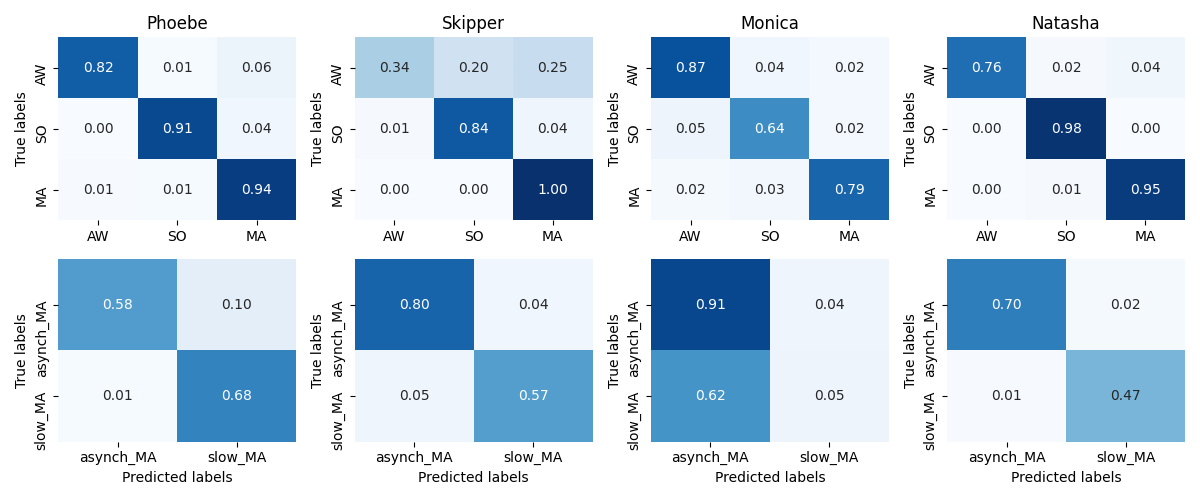

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
# choose confidence threshold
thr = 0.9

cm_avg_mod1 = np.array([])
cm_avg_mod2 = np.array([])

### ONLY GOOD SUBJECTS
names_to_test_good = [i for i in names_to_test if any([i.startswith(j) for j in ['Phoebe', 'Monica', 'Natasha', 'Skipper']])]

fig, ax = plt.subplots(nrows=2, ncols=len(names_to_test_good), figsize=(12, 5))
for sdx, name_testing_subject in enumerate(names_to_test_good):
    with open(f'testing_data/cm_model1_{name_testing_subject}_thr_{thr}.pkl', "rb") as pickle_file:
        conf = pickle.load(pickle_file)
    
    cm_normalized = conf['cm_n']
    classes = ['AW', 'SO', 'MA']
    sns.heatmap(cm_normalized[:3, :3], annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=ax[0, sdx], cbar=False, vmin=0, vmax=1)
    ax[0, sdx].set_xlabel('')
    ax[0, sdx].set_ylabel('True labels')
    ax[0, sdx].set_title(name_testing_subject)
    
    cm_avg_mod1 = np.vstack([cm_avg_mod1, [cm_normalized[:3, :3]]]) if cm_avg_mod1.size else np.array([cm_normalized[:3, :3]])
    
    with open(f'testing_data/cm_model2_{name_testing_subject}_thr_{thr}.pkl', "rb") as pickle_file:
        conf2 = pickle.load(pickle_file)
    
    cm_normalized = conf2['cm_n']
    classes = ['asynch_MA', 'slow_MA']
    sns.heatmap(cm_normalized[:2, :2], annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=ax[1, sdx], cbar=False, vmin=0, vmax=1)
    ax[1, sdx].set_xlabel('Predicted labels')
    ax[1, sdx].set_ylabel('True labels')
    
    cm_avg_mod2 = np.vstack([cm_avg_mod2, [cm_normalized[:2, :2]]]) if cm_avg_mod2.size else np.array([cm_normalized[:2, :2]])
    
plt.tight_layout()

### Figure: Average of Confusion Matrices without confidence level INCLUDING UNKNOWNS
- Plot the subject-averaged accuracies for the three major states (AW, SO , MA)

<IPython.core.display.Javascript object>


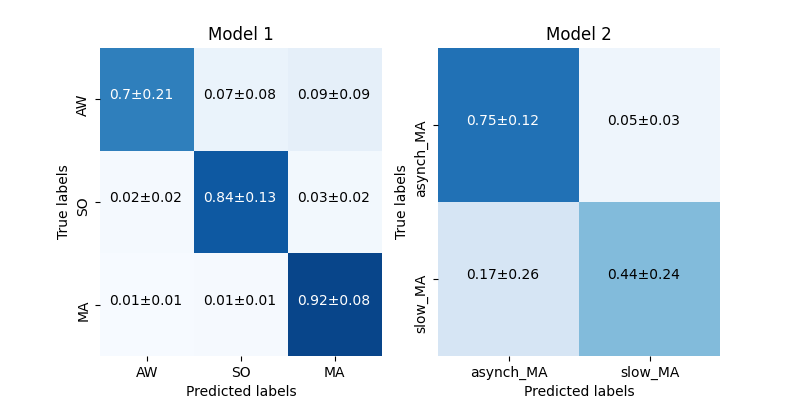

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
classes = ['AW', 'SO', 'MA']
sns.heatmap(np.mean(cm_avg_mod1, axis=0), annot=False, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=ax[0], cbar=False, vmin=0, vmax=1)
ax[0].set_xlabel('Predicted labels')
for i in range(3):
    for j in range(3):
        val_mean = np.round(np.mean(cm_avg_mod1, axis=0)[j, i], 2)
        val_std = np.round(np.std(cm_avg_mod1, axis=0)[j, i], 2)
        ax[0].text(i+0.1, j+0.5, f'{val_mean}±{val_std}', c='k' if val_mean < 0.5 else 'w')

classes = ['asynch_MA', 'slow_MA']
sns.heatmap(np.mean(cm_avg_mod2, axis=0), annot=False, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=ax[1], cbar=False, vmin=0, vmax=1)
ax[0].set_ylabel('True labels')
ax[1].set_ylabel('True labels')
ax[0].set_title('Model 1')
ax[1].set_title('Model 2')
ax[1].set_xlabel('Predicted labels')
for i in range(2):
    for j in range(2):
        val_mean = np.round(np.mean(cm_avg_mod2, axis=0)[j, i], 2)
        val_std = np.round(np.std(cm_avg_mod2, axis=0)[j, i], 2)
        ax[1].text(i+0.2, j+0.5, f'{val_mean}±{val_std}', c='k' if val_mean < 0.5 else 'w')

In [ ]:
plt.savefig('C:\\Users\\manasanch.IBP10386\\Downloads\\model1model2_accuracies.svg', dpi=600)

### Figure: Confusion Matrices without confidence level EXCLUDING UNKNOWNS
- Plot the confusion matrices for all states and subjects given a confidence threshold `thr`

<IPython.core.display.Javascript object>


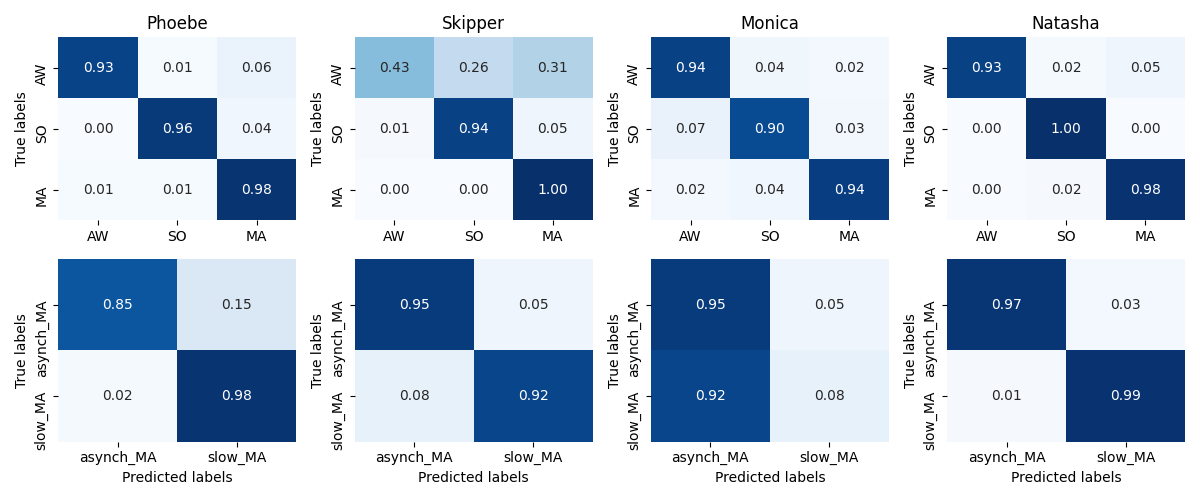

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
# choose confidence threshold
thr = 0.9

cm_avg_mod1_wUK = np.array([])
cm_avg_mod2_wUK = np.array([])

### ONLY GOOD SUBJECTS
names_to_test_good = [i for i in names_to_test if any([i.startswith(j) for j in ['Phoebe', 'Monica', 'Natasha', 'Skipper']])]

fig, ax = plt.subplots(nrows=2, ncols=len(names_to_test_good), figsize=(12, 5))
for sdx, name_testing_subject in enumerate(names_to_test_good):
    with open(f'testing_data/cm_wUK_model1_{name_testing_subject}_thr_{thr}.pkl', "rb") as pickle_file:
        conf = pickle.load(pickle_file)
    
    cm_normalized = conf['cm_n']
    classes = ['AW', 'SO', 'MA']
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=ax[0, sdx], cbar=False, vmin=0, vmax=1)
    ax[0, sdx].set_xlabel('')
    ax[0, sdx].set_ylabel('True labels')
    ax[0, sdx].set_title(name_testing_subject)
    
    cm_avg_mod1_wUK = np.vstack([cm_avg_mod1_wUK, [cm_normalized]]) if cm_avg_mod1_wUK.size else np.array([cm_normalized])
    
    with open(f'testing_data/cm_wUK_model2_{name_testing_subject}_thr_{thr}.pkl', "rb") as pickle_file:
        conf2 = pickle.load(pickle_file)
    
    cm_normalized = conf2['cm_n']
    classes = ['asynch_MA', 'slow_MA']
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=ax[1, sdx], cbar=False, vmin=0, vmax=1)
    ax[1, sdx].set_xlabel('Predicted labels')
    ax[1, sdx].set_ylabel('True labels')
    
    cm_avg_mod2_wUK = np.vstack([cm_avg_mod2_wUK, [cm_normalized]]) if cm_avg_mod2_wUK.size else np.array([cm_normalized])
    
plt.tight_layout()

### Figure: Average of Confusion Matrices without confidence level EXCLUDING UNKNOWNS
- Plot the subject-averaged accuracies for the three major states (AW, SO , MA)

<IPython.core.display.Javascript object>


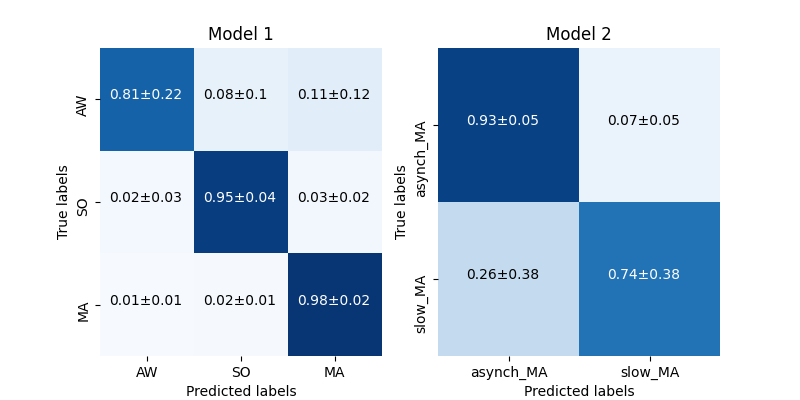

In [20]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
classes = ['AW', 'SO', 'MA']
sns.heatmap(np.mean(cm_avg_mod1_wUK, axis=0), annot=False, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=ax[0], cbar=False, vmin=0, vmax=1)
ax[0].set_xlabel('Predicted labels')
for i in range(3):
    for j in range(3):
        val_mean = np.round(np.mean(cm_avg_mod1_wUK, axis=0)[j, i], 2)
        val_std = np.round(np.std(cm_avg_mod1_wUK, axis=0)[j, i], 2)
        ax[0].text(i+0.1, j+0.5, f'{val_mean}±{val_std}', c='k' if val_mean < 0.5 else 'w')

classes = ['asynch_MA', 'slow_MA']
sns.heatmap(np.mean(cm_avg_mod2_wUK, axis=0), annot=False, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=ax[1], cbar=False, vmin=0, vmax=1)
ax[0].set_ylabel('True labels')
ax[1].set_ylabel('True labels')
ax[0].set_title('Model 1')
ax[1].set_title('Model 2')
ax[1].set_xlabel('Predicted labels')
for i in range(2):
    for j in range(2):
        val_mean = np.round(np.mean(cm_avg_mod2_wUK, axis=0)[j, i], 2)
        val_std = np.round(np.std(cm_avg_mod2_wUK, axis=0)[j, i], 2)
        ax[1].text(i+0.2, j+0.5, f'{val_mean}±{val_std}', c='k' if val_mean < 0.5 else 'w')

In [ ]:
plt.savefig('C:\\Users\\manasanch.IBP10386\\Downloads\\model1model2_accuracies_WITHOUTUNKNOWNS.svg', dpi=600)

### Examples of samples with different thresholds

<IPython.core.display.Javascript object>


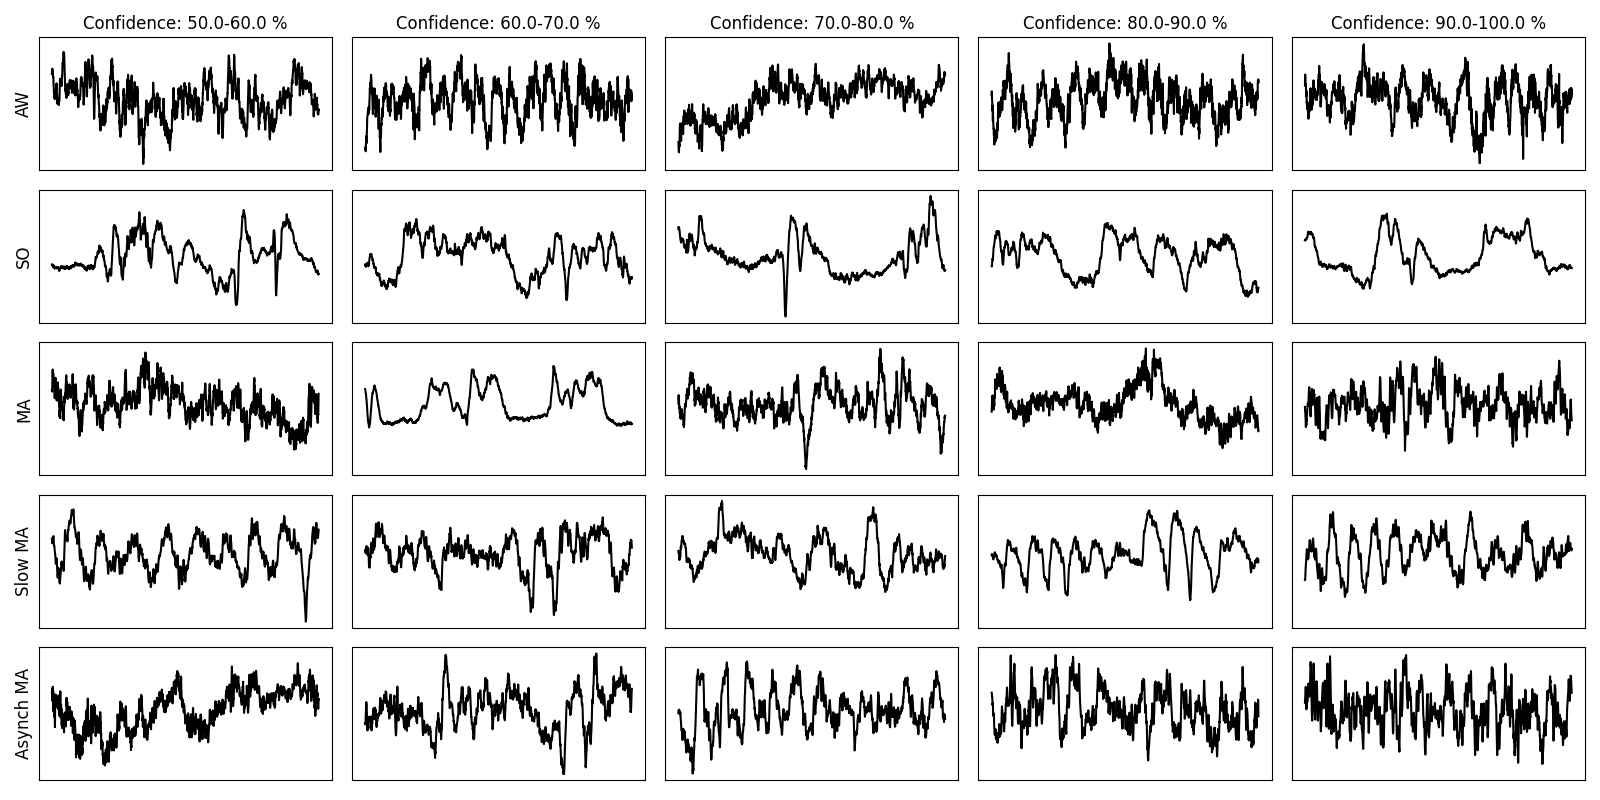

In [30]:
import os
import pickle
import pandas as pd
from IPython.display import clear_output
import scipy

name_testing_subject = 'Phoebe'
thresholds = np.arange(0.5, 1.0, 0.1)

# read dataframe for model 1
df_pred = pd.read_pickle(os.getcwd() + f'/model_df_probs/df_pred_model1_{name_testing_subject}')

thr = [0.9, 0.9]
# load model 1 and 2
df_pred['y_prob'] = [df_pred['all_preds_prob'].iloc[p] if np.max(df_pred['prob'].iloc[p]) > thr[0] else -1 for p in range(len(df_pred['prob']))]
df_pred['prob_max'] = [np.max(df_pred['prob'].iloc[p]) for p in range(len(df_pred['prob']))]
df_mod2 = pd.read_pickle(os.getcwd() + f'/model_df_probs/df_pred_model2_{name_testing_subject}')
predicted_classes = np.where(df_mod2['predictions'] > thr[1], 1, np.where(df_mod2['predictions'] <= 1 - thr[1], 0, -1)).flatten()

testing_data = np.load(f'testing_data/testing_data_{name_testing_subject}.npy')
testing_states = np.load(f'testing_data/testing_labels_{name_testing_subject}.npy')
data_test_MA = np.load(f'testing_data/testing_dataMA_{name_testing_subject}.npy')
labels_test_MA = np.load(f'testing_data/testing_labelsMA_{name_testing_subject}.npy')

fig, ax = plt.subplots(nrows=5, ncols=len(thresholds), figsize=(16, 8), sharey='row')
for tdx, threshold in enumerate(thresholds):
    thr = [threshold, threshold]

    # model 1 (AW, SO, MA)
    for sdx, state in enumerate([0, 1, 2]):
        # find indices fulfilling conditions of state and threshold bin
        state_indices = df_pred.loc[((df_pred['all_preds_prob']==state)&((df_pred['prob_max']>=threshold)&(df_pred['prob_max']<=(threshold+0.1))))].index.values
        # maybe some are empty
        if len(state_indices):
            # choose random indices
            selected_indices = np.random.choice(state_indices, 1)
            # loop and plot
            for seldx, selected in enumerate(selected_indices):
                ax[sdx, tdx].plot(scipy.stats.zscore(testing_data[selected, :]), c='k')
                ax[sdx, tdx].set_xticks([])
                ax[sdx, tdx].set_yticks([])
                if not sdx:
                    ax[sdx, tdx].set_title(f"Confidence: {np.round(100*threshold, 2)}-{np.round(100*(threshold+0.1),2)} %")
                
    # model 2 (slow_MA, asynch_MA)           
    state_indices_slowMA = df_mod2.loc[((df_mod2['y_pred']==1)&((df_mod2['predictions']>=threshold)&(df_mod2['predictions']<=threshold+0.1)))].index.values
    state_indices_asynchMA = df_mod2.loc[((df_mod2['y_pred']==0)&((df_mod2['predictions']<=1-threshold)&(df_mod2['predictions']>=1-threshold-0.1)))].index.values
    # maybe some are empty
    if len(state_indices_slowMA):
        # choose random indices
        selected_indices = np.random.choice(state_indices_slowMA, 1)
        # loop and plot
        for seldx, selected in enumerate(selected_indices):
            ax[3, tdx].plot(data_test_MA[selected, :], c='k')
            ax[3, tdx].set_xticks([])
            ax[3, tdx].set_yticks([])
    # maybe some are empty
    if len(state_indices_asynchMA):
        # choose random indices
        selected_indices = np.random.choice(state_indices_asynchMA, 1)
        # loop and plot
        for seldx, selected in enumerate(selected_indices):
            ax[4, tdx].plot(data_test_MA[selected, :], c='k')
            ax[4, tdx].set_xticks([])
            ax[4, tdx].set_yticks([])
            
ax[0, 0].set_ylabel('AW', fontsize=12)
ax[1, 0].set_ylabel('SO', fontsize=12)
ax[2, 0].set_ylabel('MA', fontsize=12)
ax[3, 0].set_ylabel('Slow MA', fontsize=12)
ax[4, 0].set_ylabel('Asynch MA', fontsize=12)
plt.tight_layout()

In [ ]:
plt.savefig('C:\\Users\\manasanch.IBP10386\\Downloads\\confidence_traces.svg', dpi=600)

### Figure precision, recall and F1-score (taking into account UNKNOWNS)

<IPython.core.display.Javascript object>


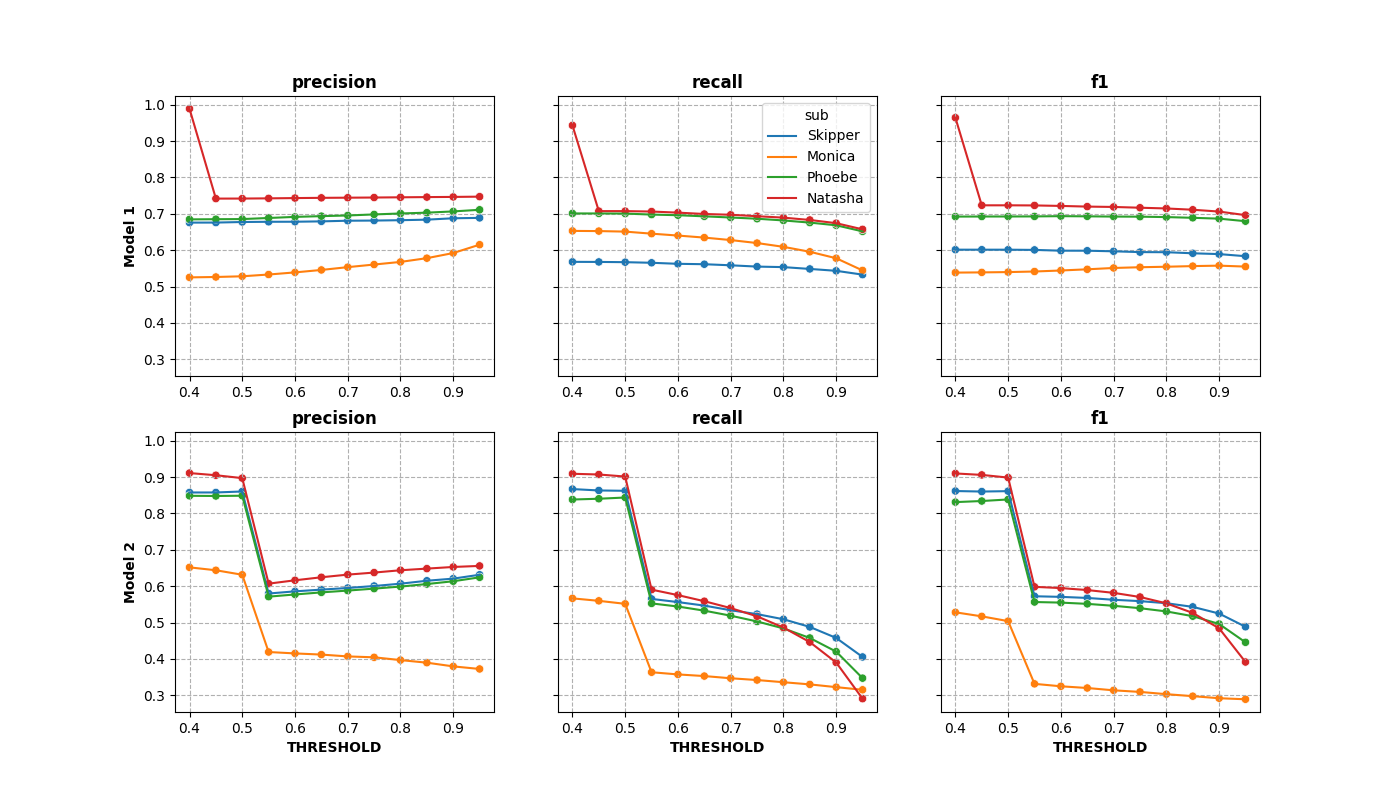

Text(0, 0.5, 'Model 2')

In [31]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(14, 8), sharex=False, sharey=True)
for mdx, metric in enumerate(['precision', 'recall', 'f1']):
    leg_viz = True if mdx == 1 else False
    sns.lineplot(data=df_metrics.loc[df_metrics['model']==1], x='thr', y=metric, hue='sub', ax=ax[0, mdx], legend=leg_viz)
    sns.scatterplot(data=df_metrics.loc[df_metrics['model']==1], x='thr', y=metric, hue='sub', ax=ax[0, mdx], legend=False)
    ax[0, mdx].set_title(f'{metric}', fontweight='bold')
    ax[0, mdx].set_xlabel('')
    ax[0, mdx].grid(linestyle='--')

for mdx, metric in enumerate(['precision', 'recall', 'f1']):
    sns.lineplot(data=df_metrics.loc[df_metrics['model']==2], x='thr', y=metric, hue='sub', ax=ax[1, mdx], legend=False)
    sns.scatterplot(data=df_metrics.loc[df_metrics['model']==2], x='thr', y=metric, hue='sub', ax=ax[1, mdx], legend=False)
    ax[1, mdx].set_title(f'{metric}', fontweight='bold')
    ax[1, mdx].set_xlabel('THRESHOLD', fontweight='bold')
    ax[1, mdx].grid(linestyle='--')

ax[0, 0].set_ylabel('Model 1', fontweight='bold')
ax[1, 0].set_ylabel('Model 2', fontweight='bold')

### Figure precision, recall and F1-score (NOT taking into account UNKNOWNS)

<IPython.core.display.Javascript object>


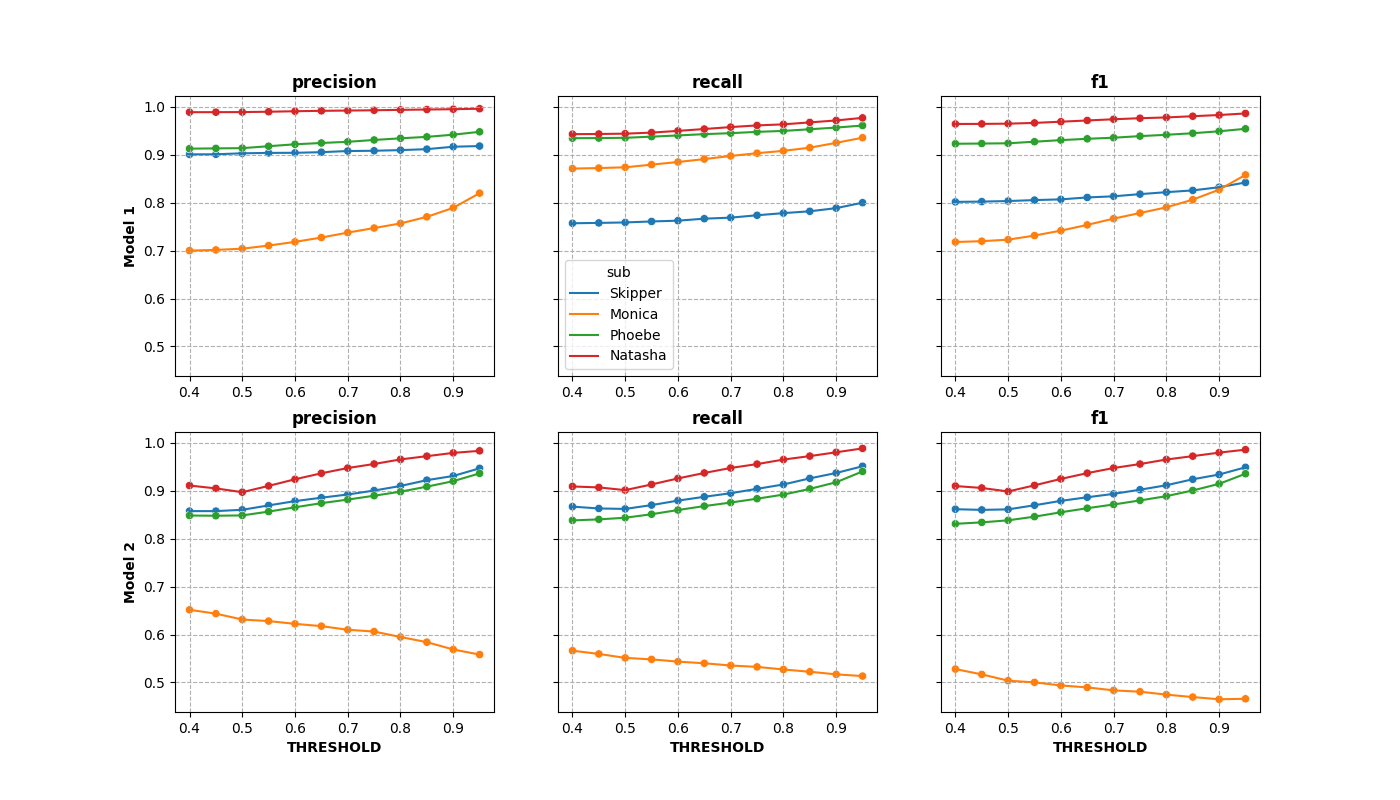

Text(0, 0.5, 'Model 2')

In [32]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(14, 8), sharex=False, sharey=True)
for mdx, metric in enumerate(['precision', 'recall', 'f1']):
    leg_viz = True if mdx == 1 else False
    sns.lineplot(data=df_metrics_nounknown.loc[df_metrics['model']==1], x='thr', y=metric, hue='sub', ax=ax[0, mdx], legend=leg_viz)
    sns.scatterplot(data=df_metrics_nounknown.loc[df_metrics['model']==1], x='thr', y=metric, hue='sub', ax=ax[0, mdx], legend=False)
    ax[0, mdx].set_title(f'{metric}', fontweight='bold')
    ax[0, mdx].set_xlabel('')
    ax[0, mdx].grid(linestyle='--')

for mdx, metric in enumerate(['precision', 'recall', 'f1']):
    sns.lineplot(data=df_metrics_nounknown.loc[df_metrics['model']==2], x='thr', y=metric, hue='sub', ax=ax[1, mdx], legend=False)
    sns.scatterplot(data=df_metrics_nounknown.loc[df_metrics['model']==2], x='thr', y=metric, hue='sub', ax=ax[1, mdx], legend=False)
    ax[1, mdx].set_title(f'{metric}', fontweight='bold')
    ax[1, mdx].set_xlabel('THRESHOLD', fontweight='bold')
    ax[1, mdx].grid(linestyle='--')

ax[0, 0].set_ylabel('Model 1', fontweight='bold')
ax[1, 0].set_ylabel('Model 2', fontweight='bold')

In [ ]:
plt.savefig('C:\\Users\\manasanch.IBP10386\\Downloads\\recall_prec_f1_withoutUNKNOWNS.svg', dpi=600)

### Figure: Accuracies of state dependant of the threshold

<IPython.core.display.Javascript object>


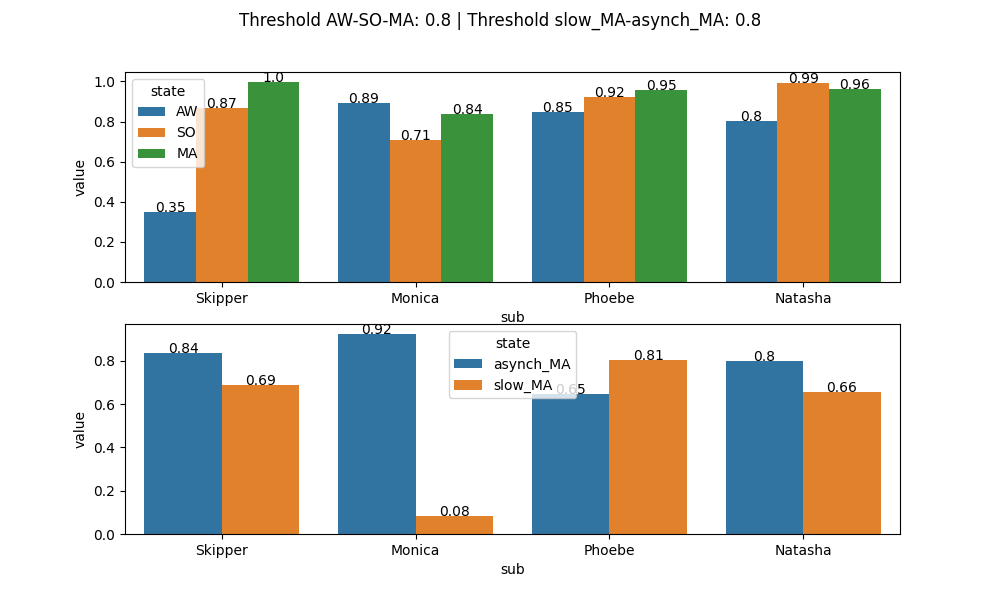

Text(0.5, 0.98, 'Threshold AW-SO-MA: 0.8 | Threshold slow_MA-asynch_MA: 0.8')

In [33]:
%matplotlib notebook
thr = [0.8, 0.8]
fig, ax = plt.subplots(nrows=2, figsize=(10, 6))
bars = sns.barplot(data=df_acc.loc[((df_acc['state']!='unknown')&(df_acc['thr']==thr[0]))], x='sub', y='value', hue='state', ax=ax[0])
# Add the values on top of each bar
for p in bars.patches:
    ax[0].annotate(f'{np.round(p.get_height(), 2)}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
bars_MA = sns.barplot(data=df_acc_MA.loc[((df_acc_MA['state']!='unknown')&(df_acc_MA['thr']==thr[1]))], x='sub', y='value', hue='state', ax=ax[1])
# Add the values on top of each bar
for p in bars_MA.patches:
    ax[1].annotate(f'{np.round(p.get_height(), 2)}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
    
fig.suptitle(f'Threshold AW-SO-MA: {thr[0]} | Threshold slow_MA-asynch_MA: {thr[1]}')